# Decision Tree Lab

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt

## 1. Implement the ID3 decision tree algorithm  
- Use standard information gain as your basic attribute evaluation metric.  Note that ID3 would usually augment information gain with a mechanism to penalize statistically insignificant attribute splits to avoid overfit (e.g. early stopping, gain ratio, etc.)
- Include the ability to handle unknown attributes by making "unknown" a separate output class.
- You do not need to handle real valued attributes.
- You are welcome to create other classes and/or functions in addition to the ones provided below. (e.g. If you build out a tree structure, you might create a node class).
- It is a good idea to use simple data sets (like the lenses data and the pizza homework), which you can check by hand, to test each detailed step of your algorithm to make sure it works correctly. 

In [513]:
def add_unknown_class(X):
    for x in X:
        for i in range(len(x)):
            if np.isnan(x[i]):
                x[i] = -1
    
    maxes = np.amax(X,axis=0)
    for x in X:
        for i in range(len(x)):
            if x[i] == -1:
                x[i] = maxes[i] + 1

In [533]:
class TreeNode():
    def __init__(self, X, y, attributes, counts, names, output=-1, depth=0, is_leaf=False):
        self.X = X
        self.y = y
        self.attributes = attributes
        self.counts = counts
        self.names = names
        self.depth = depth
        self.info = None
        self.children = []
        self.output = None
        self.majority_class = None
        self.attribute_gains = []
        self.is_leaf = is_leaf

        if X is None and y is None or is_leaf:
            self.output = output
        else:
            self.info = self.calculate_info(X, y)
            self.create_children()

        # Compute majority class
        if y is not None:
            self.majority_class = np.argmax(np.bincount(y.astype(int).squeeze()))

    def create_children(self):
        # Calculate gain for each remaining attribute
        self.attribute_gains = []

        # Only calcuate gain when the attribute is still left, otherwise give it -1
        for i in range(len(self.counts)-1):
            if self.attributes[i] == 1:
                self.attribute_gains.append(self.info - self.calculate_attribute_info(i, self.X, self.y))
            else:
                self.attribute_gains.append(-1)

        self.output = np.argmax(self.attribute_gains) # Choose attribute to split on (highest gain)
        
        self.attributes[self.output] = -1 # Update self.attributes list

        for i in range(self.counts[self.output]): # yes and no are i=0 and i=1
            # Update X and y in their proper splits:
            X_y = np.hstack((self.X, self.y))
            X_y = X_y[X_y[:,self.output]==i]
            new_X = X_y[:,:-1]
            new_y = np.expand_dims(X_y[:,-1], axis=1)

            if len(new_y) == 0:
                self.children.append(None)
                continue

            if np.all(new_y == new_y[0]): # if the remaining data only contains one class, it is a leaf node.
                self.children.append(TreeNode(None, None, self.attributes, self.counts, self.names, int(new_y[0][0]), self.depth + 1, is_leaf=True))
            else:
                self.children.append(TreeNode(new_X, new_y, self.attributes, self.counts, self.names, depth=self.depth + 1))
        self.attributes[self.output] = 1 # Update self.attributes list
    
    def predict(self, x):
        # Predicts a single x
        if self.is_leaf:
            return self.output
        
        child = self.children[int(x[self.output])]

        if child is None:
            return self.majority_class
        else:
            return child.predict(x)


    def print(self):
        if self.is_leaf:
            print(f"{'    '*(self.depth+1)}Prediction = {self.names[-1][list(self.names[-1].keys())[0]][self.output]}")
        else:
            feature_name = list(self.names[self.output].keys())[0]
            for i in range(self.counts[self.output]):
                if self.children[i] is None:
                    continue
                value_name = self.names[self.output][feature_name][i]
                print(f"{'    '*(self.depth+1)}{feature_name} = {value_name}: {self.attribute_gains[self.output]}")
                self.children[i].print()
    
    def calculate_info(self, X, y):
        p = [np.count_nonzero(y == i)/len(y) if len(y) != 0 else 0 for i in range(self.counts[-1])]
        info = -sum([p[i]*self.log(p[i]) for i in range(self.counts[-1])])
        return info

    def log(self, val):
        if val == 0:
            return -1
        else:
            return np.log2(val)

    def calculate_attribute_info(self, attr_index, X, y):
        X_y = np.hstack((X, y))
        s = [np.count_nonzero(X_y[:,attr_index] == i)/len(X_y) for i in range(self.counts[attr_index])]
        subset_arrays = [X_y[X_y[:,attr_index]==i]for i in range(self.counts[attr_index])]
        assert len(s) == len(subset_arrays)
        attr_info = sum([s[i] * self.calculate_info(subset_arrays[i][:,:-1], np.expand_dims(subset_arrays[i][:,-1], axis=1)) for i in range(len(s))])
        return attr_info


In [534]:
class DTClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self,counts=None, names=None):
        """ Initialize class with chosen hyperparameters.
        Args:
        Optional Args (Args we think will make your life easier):
            counts: A list of Ints that tell you how many types of each feature there are
        Example:
            DT  = DTClassifier()
            or
            DT = DTClassifier(count = [2,3,2,2])
            Dataset = 
            [[0,1,0,0],
            [1,2,1,1],
            [0,1,1,0],
            [1,2,0,1],
            [0,0,1,1]]

        """
        self.counts = counts
        self.names = names
        self.tree = None
        

    def fit(self, X, y):
        """ Fit the data; Make the Decision tree

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 1D numpy array with the training targets

        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        attributes = [1 for i in range(len(self.counts)-1)] # 1 if the attribute is remaining, 0 if already used
        self.tree = TreeNode(X, y, attributes, self.counts, self.names)
        
        return self

    def predict(self, X):
        """ Predict all classes for a dataset X

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets

        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        return np.array([self.tree.predict(x) for x in X])


    def score(self, X, y):
        """ Return accuracy(Classification Acc) of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 1D numpy array of the targets 
        """
        pred = self.predict(X)

        correct = 0
        for y_hat, y_truth in zip(pred, y):
            if y_hat == y_truth:
                correct += 1
        
        return correct / len(y)

    def print(self):
        self.tree.print()



### 1.1 (20%) Debug 

- Debug your model by training on the lenses dataset: [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses.arff)
- Test your model on the lenses test set: [Debug Test Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses_test.arff)
- Parameters:
For this problem the number of unique feature values for each feature is: counts = [3,2,2,2] (You should compute this when you read in the data, before fitting)
---

Expected Results: Accuracy = [0.33]

Information gain at splits = [0.5487949406953987, 0.7704260414863775, 0.3166890883150208, 1.0, 0.4591479170272447, 0.9182958340544894]

Predictions should match this file: [Lenses Predictions](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/pred_lenses.csv)

*NOTE: The [Lenses Prediction](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/pred_lenses.csv) uses the following encoding: soft=2, hard=0, none=1. Use this same encoding.*

<!-- You should be able to get about 68% (61%-82%) predictive accuracy on the lenses data -->

Here's what your decision tree splits and information gains should look like, with the corresponding child node predictions:

<pre>
tear_prod_rate = normal: 0.5487949406953987
    astigmatism = no: 0.7704260414863775
        age = pre_presbyopic: 0.3166890883150208
            prediction: soft
        age = presbyopic:
            spectacle_prescrip = hypermetrope: 1.0
                prediction: soft
            spectacle_prescrip = myope:
                prediction: none
        age = young:
            prediction: soft
    astigmatism = yes:
        spectacle_prescrip = hypermetrope: 0.4591479170272447
            age = pre_presbyopic: 0.9182958340544894
                prediction: none
            age = presbyopic:
                prediction: none
            age = young:
                prediction: hard
        spectacle_prescrip = myope:
            prediction: hard
tear_prod_rate = reduced:
    prediction: none
</pre>

In [535]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses.arff --output lenses.arff
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses_test.arff --output lenses_test.arff

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2890  100  2890    0     0  39087      0 --:--:-- --:--:-- --:--:-- 41285
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2839  100  2839    0     0  30307      0 --:--:-- --:--:-- --:--:-- 31544


In [536]:
import arff

In [537]:
# Load debug training data
arff_path = "lenses.arff"
lenses_data = arff.Arff(arff=arff_path, label_count=1)[:]
X = lenses_data[:,:4]
y = np.expand_dims(lenses_data[:,4], axis=1)

# Train Decision Tree
names = [
    {"age": ["young", "pre_presbyopic", "presbyopic"]}, 
    {"spectacle_prescrip": ["myope", "hypermetrope"]}, 
    {"astigmatism": ["no","yes"]}, 
    {"tear_prod_rate": ["reduced", "normal"]},
    {"contact_lenses": ["soft", "hard", "none"]}]
model = DTClassifier(counts=[3,2,2,2,3], names=names)

model.fit(X, y)
model.print()

# Load debug test data
arff_path = "lenses_test.arff"
lenses_test_data = arff.Arff(arff=arff_path, label_count=1)[:]
X_test = lenses_test_data[:,:4]
y_test = np.expand_dims(lenses_test_data[:,4], axis=1)

# Execute and print the model accuracy and the information gain of every split you make
print(f"Accuracy on Test Set: {model.score(X_test, y_test)}")

    tear_prod_rate = reduced: 0.5487949406953986
        Prediction = none
    tear_prod_rate = normal: 0.5487949406953986
        astigmatism = no: 0.7704260414863776
            age = young: 0.3166890883150208
                Prediction = soft
            age = pre_presbyopic: 0.3166890883150208
                Prediction = soft
            age = presbyopic: 0.3166890883150208
                spectacle_prescrip = myope: 1.0
                    Prediction = none
                spectacle_prescrip = hypermetrope: 1.0
                    Prediction = soft
        astigmatism = yes: 0.7704260414863776
            spectacle_prescrip = myope: 0.4591479170272448
                Prediction = hard
            spectacle_prescrip = hypermetrope: 0.4591479170272448
                age = young: 0.9182958340544896
                    Prediction = hard
                age = pre_presbyopic: 0.9182958340544896
                    Prediction = none
                age = presbyopic: 0.9182958340544896


Discussion

The decision tree algorithm takes in a counts array that includes the number of classes for each feature and the number of output classes. It also takes in a names list of dictionaries that simply contain the names of the features and the names of the classes. It can handle unknowns by adding an additional class (of unknown) if there is an unknown value, which must be done in the preprocessing phase before the data is fit to the model. The Decision tree model creates a root node of the first split by calculating the information gain of all the remaining attributes and taking the maximum as the split criteria. It then creates children nodes recursively until it reaches a leaf node by having either no more data or being all the same output class.

The model peformed as expected on the debug lenses set and got an accuracy of .33 on the test set.

In [538]:
# Pizza Debugging

pizza_data = np.array([
    [1, 2, 0, 2],
    [0, 0, 0, 0],
    [0, 1, 1, 1],
    [1, 1, 1, 2],
    [1, 0, 0, 1],
    [1, 0, 1, 2],
    [0, 2, 1, 1],
    [1, 0, 0, 1],
    [0, 2, 0, 0]
    ])
pizza_X = pizza_data[:,:-1]
pizza_y = np.expand_dims(pizza_data[:,-1], axis=1)

names = [{"meat": ["no", "yes"]}, {"crust": ["deep", "thin", "stuffed"]}, {"veg": ["no", "yes"]}, {"quality": ["bad", "good", "great"]}]

classifier = DTClassifier(counts=[2,3,2,3], names=names)
classifier.fit(pizza_X, pizza_y)
classifier.print()
classifier.score(pizza_X, pizza_y)

    meat = no: 0.5466316153937778
        veg = no: 1.0
            Prediction = bad
        veg = yes: 1.0
            Prediction = good
    meat = yes: 0.5466316153937778
        crust = deep: 0.4199730940219749
            veg = no: 0.9182958340544896
                Prediction = good
            veg = yes: 0.9182958340544896
                Prediction = great
        crust = thin: 0.4199730940219749
            Prediction = great
        crust = stuffed: 0.4199730940219749
            Prediction = great


1.0

### 1.2 (20%) Evaluation 

- We will evaluate your model based on its performance on the zoo dataset. 
- Train your model using this dataset: [Evaluation Train Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo.arff)
- Test your model on this dataset: [Evaluation Test Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo_test.arff)
- Parameters: counts = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2] (You should compute this when you read in the data, before fitting)
---
Your progam should print out your accuracy on the evaluation test dataset and also the information gain of each split you make.

In [526]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo.arff --output zoo.arff
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo_test.arff --output zoo_test.arff

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6683  100  6683    0     0  24250      0 --:--:-- --:--:-- --:--:-- 24751
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  171k  100  171k    0     0   229k      0 --:--:-- --:--:-- --:--:--  231k


In [543]:
# Load evaluation training data
arff_path = "zoo.arff"
zoo_data = arff.Arff(arff=arff_path, label_count=1)[:]
num_features = len(zoo_data[0]) - 1
X = zoo_data[:,:num_features]
y = np.expand_dims(zoo_data[:,num_features], axis=1)

counts = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 7]
names = [
    {"hair": ["F", "T"]}, 
    {"feathers": ["F", "T"]}, 
    {"eggs": ["F", "T"]}, 
    {"milk": ["F", "T"]},
    {"airborne": ["F", "T"]},
    {"predator": ["F", "T"]}, 
    {"aquatic": ["F", "T"]}, 
    {"toothed": ["F", "T"]}, 
    {"backbone": ["F", "T"]},
    {"breathes": ["F", "T"]},
    {"venomous": ["F", "T"]},
    {"fins": ["F", "T"]}, 
    {"legs": ["0", "2", "4", "5", "6", "7", "8"]}, 
    {"tails": ["F", "T"]}, 
    {"domestic": ["F", "T"]},
    {"catsize": ["F", "T"]},
    {"type": ["cT","c2","c3","c4","c5","c6","c7"]}
    ]

# Train Decision Tree
classifier = DTClassifier(counts=counts, names=names)
classifier.fit(X, y)

# Load evaluation test data
arff_path = "zoo_test.arff"
zoo_test_data = arff.Arff(arff=arff_path, label_count=1)[:]
num_features = len(zoo_test_data[0]) - 1
X_test = zoo_test_data[:,:num_features]
y_test = np.expand_dims(zoo_test_data[:,num_features], axis=1)

# Execute and print the model accuracy and the information gain of every split you make
print(f"Test Accuracy: {classifier.score(X_test, y_test)}")
classifier.print()

Test Accuracy: 0.1428
    legs = 0: 1.3630469031539394
        fins = F: 0.8865408928220899
            toothed = F: 0.9852281360342515
                Prediction = c7
            toothed = T: 0.9852281360342515
                Prediction = c3
        fins = T: 0.8865408928220899
            eggs = F: 0.6962122601251458
                Prediction = cT
            eggs = T: 0.6962122601251458
                Prediction = c4
    legs = 2: 1.3630469031539394
        hair = F: 0.8256265261578954
            Prediction = c2
        hair = T: 0.8256265261578954
            Prediction = cT
    legs = 4: 1.3630469031539394
        hair = F: 0.6892019851173654
            predator = F: 0.8631205685666308
                Prediction = c3
            predator = T: 0.8631205685666308
                toothed = F: 0.7219280948873623
                    Prediction = c7
                toothed = T: 0.7219280948873623
                    Prediction = c5
        hair = T: 0.6892019851173654
            P

Discussion

Here we train the decision tree classifier on the zoo dataset. This has far more features and more output classes. The tree is still able to create a tree but it only gets an accuracy of .1428 on the zoo test set. The splits can be seen above.

## 2. Learn Cars and Voting Data Sets and Predict accuracy with *n*-fold CV  
- Use your ID3 algorithm to induce decision trees for the cars dataset and the voting dataset.  Do not use a stopping criteria, but induce the tree as far as it can go (until classes are pure or there are no more data or attributes to split on).
- Implement and use 10-fold Cross Validation (CV) on each data set to predict how well the models will do on novel data.  
- For each dataset, create a table with the training, validation, and test classification accuracy for each of the 10 runs and the average accuracies for the training, validation, and test data. 
- As a rough sanity check, typical decision tree accuracies for these data sets are: Cars: .90-.95, Vote: .92-.95.

### 2.1 (15%) Implement 10-fold Cross Validation and report results for the Cars Dataset
- Use this [Cars Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/cars.arff)
- Create a table for your *n*-fold cross validation accuracies

In [354]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/cars.arff --output cars.arff

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55386  100 55386    0     0   196k      0 --:--:-- --:--:-- --:--:--  199k


In [361]:
from sklearn.model_selection import train_test_split

In [575]:
arff_path = "cars.arff"
cars_data = arff.Arff(arff=arff_path, label_count=1)[:]
num_features = len(cars_data[0]) - 1
X = cars_data[:,:num_features]
y = np.expand_dims(cars_data[:,num_features], axis=1)

counts = [4,4,4,3,3,3,4]
names = [
    {"buying": ["vhigh", "high", "med", "low"]},
    {"maint": ["vhigh", "high", "med", "low"]},
    {"doors": ["2", "3", "4", "5more"]},
    {"persons": ["2", "4", "more"]},
    {"lug_boot": ["low", "med", "big"]},
    {"safety": ["low", "med", "high"]},
    {"class": ["unacc","acc","good","vgood"]}
]

In [576]:
# Write a function that implements 10-fold cross validation

def cv(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    models = []
    train_accs = []
    val_accs = []
    test_accs = []
    
    # get 10% of the data
    tenth = len(X_train) // 10
    
    for i in range(10):
        # split off 10% of data
        if i == 0:
            X_val = X_train[:tenth]
            y_val = y_train[:tenth]
            X_loc_train = X_train[tenth:]
            y_loc_train = y_train[tenth:]
        elif i == 9:
            X_val = X_train[tenth*i:]
            y_val = y_train[tenth*i:]
            X_loc_train = X_train[:tenth*i]
            y_loc_train = y_train[:tenth*i]
        else:
            X_val = X_train[tenth*(i-1):tenth*i]
            y_val = y_train[tenth*(i-1):tenth*i]
            X_loc_train = np.concatenate((X_train[:tenth*(i-1)], X_train[tenth*i:]), axis=0)
            y_loc_train = np.concatenate((y_train[:tenth*(i-1)], y_train[tenth*i:]), axis=0)

        # Train model on local training set
        model.fit(X_loc_train, y_loc_train)
        models.append(model)
        train_accs.append(model.score(X_loc_train, y_loc_train))
        val_accs.append(model.score(X_val, y_val))
        test_accs.append(model.score(X_test, y_test))

    return train_accs, val_accs, test_accs, models
    
    

In [577]:
# Use 10-fold CV on Cars Dataset
decision_tree = DTClassifier(counts=counts, names=names)
train_accs, val_accs, test_accs, models = cv(decision_tree, X, y)

In [578]:
print("Cars Dataset Results")
print("Train\tVal\tTest")
for i in range(len(train_accs)):
    print(f"{train_accs[i]:.4f}\t{val_accs[i]:.4f}\t{test_accs[i]:.4f}")

Cars Dataset Results
Train	Val	Test
1.0000	0.8774	0.9306
1.0000	0.8774	0.9306
1.0000	0.8903	0.9249
1.0000	0.8839	0.9480
1.0000	0.9484	0.9422
1.0000	0.9355	0.9364
1.0000	0.9097	0.9306
1.0000	0.9097	0.9191
1.0000	0.9161	0.9133
1.0000	0.9125	0.9422


In [579]:
models[7].print()

    safety = low: 0.26277837321034037
        Prediction = unacc
    safety = med: 0.26277837321034037
        persons = 2: 0.30500757223003205
            Prediction = unacc
        persons = 4: 0.30500757223003205
            buying = vhigh: 0.25529910295437785
                maint = vhigh: 0.3251898701384528
                    Prediction = unacc
                maint = high: 0.3251898701384528
                    Prediction = unacc
                maint = med: 0.3251898701384528
                    lug_boot = low: 0.7245112497836532
                        Prediction = unacc
                    lug_boot = med: 0.7245112497836532
                        doors = 2: 0.9182958340544896
                            Prediction = unacc
                        doors = 3: 0.9182958340544896
                            Prediction = unacc
                        doors = 5more: 0.9182958340544896
                            Prediction = acc
                    lug_boot = big: 0.724511249783653

Discussion

The cross validation function (named `cv()`) first splits the data into a train/test split (with a 10% size test set). Then it takes the train data and splits that into 10 even (as even as possible) parts. We loop through these parts making each act as the validation set with the remaining data acting as the training data that fits to the model. The train, validation, and test set accuracy results are shown above. The maximum test accuracy is .9538 and the maximum validation accuracy is .9626.

### 2.3 (15%) Voting Dataset 
- Use this [Voting Dataset with missing values](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff)
- Create a table for your *n*-fold cross validation accuracies
- This data set has don't know data.  Discuss how your algorithm handles this

In [568]:
# Use 10-fold CV on Voting Dataset
arff_path = "voting_with_missing.arff"
voting_with_missing_data = arff.Arff(arff=arff_path, label_count=1)[:]

num_features = len(voting_with_missing_data[0]) - 1
X = voting_with_missing_data[:,:num_features]
y = np.expand_dims(voting_with_missing_data[:,num_features], axis=1)
feature_names = []
for i in range(len(X[0])):
    feature_names.append(arff.Arff(arff=arff_path, label_count=1).attr_name(i))

add_unknown_class(X)

counts = [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2] # Add 1 to each of the features because of missing data
names = [
    {'handicapped-infants': ['n', 'y', 'unk']},
    {'water-project-cost-sharing': ['n', 'y', 'unk']},
    {'adoption-of-the-budget-resolution': ['n', 'y', 'unk']},
    {'physician-fee-freeze': ['n', 'y', 'unk']},
    {'el-salvador-aid': ['n', 'y', 'unk']},
    {'religious-groups-in-schools': ['n', 'y', 'unk']},
    {'anti-satellite-test-ban': ['n', 'y', 'unk']},
    {'aid-to-nicaraguan-contras': ['n', 'y', 'unk']},
    {'mx-missile': ['n', 'y', 'unk']},
    {'immigration': ['n', 'y', 'unk']},
    {'synfuels-corporation-cutback': ['n', 'y', 'unk']},
    {'education-spending': ['n', 'y', 'unk']},
    {'superfund-right-to-sue': ['n', 'y', 'unk']},
    {'crime': ['n', 'y', 'unk']},
    {'duty-free-exports': ['n', 'y', 'unk']},
    {'export-administration-act-south-africa': ['n', 'y', 'unk']},
    {'Class': ['democrat', 'republican']}
]

# Make sure it handles don't know inputs
decision_tree = DTClassifier(counts=counts, names=names)
train_accs, val_accs, test_accs, models = cv(decision_tree, X, y)


In [560]:
print("Voting Dataset Results")
print("Train\tVal\tTest")
for i in range(len(train_accs)):
    print(f"{train_accs[i]:.4f}\t{val_accs[i]:.4f}\t{test_accs[i]:.4f}")

Voting Dataset Results
Train	Val	Test
1.0000	0.9744	0.9318
1.0000	0.9744	0.9318
1.0000	0.9487	0.9545
1.0000	0.9231	0.9091
1.0000	1.0000	0.9318
1.0000	0.8718	0.9318
1.0000	0.9487	0.9091
1.0000	0.9744	0.9318
1.0000	0.9744	0.9773
1.0000	0.9250	0.9318


In [570]:
models[8].print()

    physician-fee-freeze = n: 0.7441655815227584
        adoption-of-the-budget-resolution = n: 0.03438610829050733
            education-spending = n: 0.220705483407101
                water-project-cost-sharing = n: 0.11301347743389945
                    religious-groups-in-schools = n: 0.3219280948873623
                        crime = n: 1.0
                            Prediction = democrat
                        crime = y: 1.0
                            Prediction = republican
                    religious-groups-in-schools = y: 0.3219280948873623
                        Prediction = democrat
                water-project-cost-sharing = y: 0.11301347743389945
                    Prediction = democrat
                water-project-cost-sharing = unk: 0.11301347743389945
                    Prediction = democrat
            education-spending = y: 0.220705483407101
                Prediction = democrat
            education-spending = unk: 0.220705483407101
                Predic

Discussion

I take care of the missing data by passing the X values into my `add_unknown_class()` function. This function simply takes any nan values (missing values) and replaces it with a new class representing all unknown values. This transformed data is then passed into the model as normal.

Here we train the model using cross validation and the resulting accuracies are shown above.

### 2.4 (5%) Decision Tree Intuition
- For each of the two problems above, summarize in English what the decision tree has learned (i.e. look at the induced tree and describe what "rules" it has discovered to try to solve each task). 
- If the tree is very large you can just discuss a few of the more shallow attribute combinations and the most important decisions made high in the tree.

Discuss what the Trees have learned on the 2 data sets

Cars:

This tree is huge (takes up 636 lines). At the top of the tree, it first splits on safety. If safety is `low`, the prediction is `unacc`. If the safety is `medium` or `high`, the tree continues. For a `medium` and `high` safety, if the number of people is `2`, then it predicts `unacc`. Following the `high` safety branch, it splits of the number of people next. After this, generally the lower the maintaince and the higher the number of doors, the better the purchace (`vgood` class).

Voting:

This tree is a lot smaller than the cars tree. The first split is on physician-fee-freeze. It splits into 3 branches because an unknown branch exists for when the data is missing. In the physician-fee-freeze = no branch, it splits on adoption-of-the-budget-resolution. If adoption-of-the-budget-resolution is yes or unknown, the tree classifies the person as democrat. On the other branch, going back to when physician-fee-freeze = yes instead, the tree splits on synfuels-corporation-cutback. This isn't so decisive as the previous adoption-of-the-budget-resolution. Both branches lead to both republican and democratic classes.


## 3 Using SciKit Learn's decision tree  

### 3.1 (10%) SK Learn on Voting Dataset
- Use SciKit learns decision tree (CART) on the voting dataset and compare the results with your ID3 version. Use this [Voting Dataset with missing values].(https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff)
- Try different parameters and report what parameters perform the best on the test set.

In [283]:
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff --output voting_with_missing.arff

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40261  100 40261    0     0   186k      0 --:--:-- --:--:-- --:--:--  191k


In [633]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn import tree


In [630]:
# Use SK Learn's Decision Tree to learn the voting dataset
arff_path = "voting_with_missing.arff"
voting_with_missing_data = arff.Arff(arff=arff_path, label_count=1)[:]

num_features = len(voting_with_missing_data[0]) - 1
X = voting_with_missing_data[:,:num_features]
y = np.expand_dims(voting_with_missing_data[:,num_features], axis=1)
feature_names = []
for i in range(len(X[0])):
    feature_names.append(arff.Arff(arff=arff_path, label_count=1).attr_name(i))

add_unknown_class(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Explore different parameters
decision_tree = DecisionTreeClassifier(random_state=999)
decision_tree = decision_tree.fit(X_train, y_train)


print(decision_tree.score(X_test, y_test))

decision_tree2 = DecisionTreeClassifier(max_depth=10, splitter="random").fit(X_train, y_train)

print(decision_tree2.score(X_test, y_test))

decision_tree3 = DecisionTreeClassifier(max_depth=5, criterion="log_loss").fit(X_train, y_train)

print(decision_tree3.score(X_test, y_test))

decision_tree4 = DecisionTreeClassifier(criterion="log_loss").fit(X_train, y_train)
r = export_text(decision_tree4, feature_names=feature_names)

print(decision_tree4.score(X_test, y_test))

print(r)

0.9545454545454546
0.9318181818181818
1.0
0.9318181818181818
|--- physician-fee-freeze <= 0.50
|   |--- adoption-of-the-budget-resolution <= 0.50
|   |   |--- education-spending <= 1.50
|   |   |   |--- religious-groups-in-schools <= 0.50
|   |   |   |   |--- duty-free-exports <= 0.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- duty-free-exports >  0.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- religious-groups-in-schools >  0.50
|   |   |   |   |--- class: 0.0
|   |   |--- education-spending >  1.50
|   |   |   |--- class: 1.0
|   |--- adoption-of-the-budget-resolution >  0.50
|   |   |--- class: 0.0
|--- physician-fee-freeze >  0.50
|   |--- synfuels-corporation-cutback <= 0.50
|   |   |--- immigration <= 0.50
|   |   |   |--- education-spending <= 0.50
|   |   |   |   |--- water-project-cost-sharing <= 0.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- water-project-cost-sharing >  0.50
|   |   |   |   |   |--- superfund-right-to-sue <= 1.50
|   | 

Discuss scikit CART results & also compare to your ID3 results

The best CART Decision Tree model (using log loss with max_depth=5) got 100% accuracy which is close to the same amount as my model's highest test accuracy on the dataset: 0.9773. It means my ID3 model is pretty good. The CART model doensn't use nominal data though, which is different from ID3. It still is able to do great on all nominal data, even converting it to actual real values here.

### 3.2 (10%) Choose a data set of your choice (not already used in this or previous labs) and use the SK decision tree to learn it. Experiment with different hyper-parameters to try to get the best results possible.

In [582]:
!curl https://github.com/renatopp/arff-datasets/blob/master/classification/mushroom.arff --output mushroom.arff

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4184k    0 4184k    0     0  2059k      0 --:--:--  0:00:02 --:--:-- 2065k


In [632]:
# Use SciKit Learn's Decision Tree on a new dataset
arff_path = "mushroom_arff.arff"
mushroom_data = arff.Arff(arff=arff_path, label_count=1)[:]

num_features = len(mushroom_data[0]) - 1
X = mushroom_data[:,:num_features]
y = np.expand_dims(mushroom_data[:,num_features], axis=1)
feature_names = []
for i in range(len(X[0])):
    feature_names.append(arff.Arff(arff=arff_path, label_count=1).attr_name(i))

add_unknown_class(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Explore different parameters
decision_tree = DecisionTreeClassifier(random_state=999)
decision_tree = decision_tree.fit(X_train, y_train)
r = export_text(decision_tree, feature_names=feature_names)

print(decision_tree.score(X_test, y_test))

decision_tree2 = DecisionTreeClassifier(max_depth=10, splitter="random").fit(X_train, y_train)

print(decision_tree2.score(X_test, y_test))

decision_tree3 = DecisionTreeClassifier(max_depth=5, criterion="log_loss").fit(X_train, y_train)

print(decision_tree3.score(X_test, y_test))

decision_tree4 = DecisionTreeClassifier(criterion="log_loss").fit(X_train, y_train)

print(decision_tree4.score(X_test, y_test))



1.0
1.0
0.984009840098401
1.0


Discussion

Here I used the mushroom dataset which classifies if a mushroom is poisonous to eat or not. The model gets 100% on the test set on 3/4 of my hyperparameter configurations! 

### 3.3 (5%) Print sklearn's decision tree for your chosen data set (using export_graphviz or another tool) and discuss what you find. If your tree is too deep to reasonably fit on one page, show only the first several levels (e.g. top 5).

[Text(0.2833333333333333, 0.9375, 'X[8] <= 0.5\nlog_loss = 0.999\nsamples = 7311\nvalue = [3801, 3510]'),
 Text(0.21666666666666667, 0.8125, 'log_loss = 0.0\nsamples = 1536\nvalue = [0, 1536]'),
 Text(0.35, 0.8125, 'X[19] <= 1.5\nlog_loss = 0.927\nsamples = 5775\nvalue = [3801, 1974]'),
 Text(0.13333333333333333, 0.6875, 'X[4] <= 3.5\nlog_loss = 0.31\nsamples = 1507\nvalue = [84, 1423]'),
 Text(0.06666666666666667, 0.5625, 'log_loss = 0.0\nsamples = 1423\nvalue = [0, 1423]'),
 Text(0.2, 0.5625, 'log_loss = 0.0\nsamples = 84\nvalue = [84, 0]'),
 Text(0.5666666666666667, 0.6875, 'X[7] <= 0.5\nlog_loss = 0.555\nsamples = 4268\nvalue = [3717, 551]'),
 Text(0.3333333333333333, 0.5625, 'X[19] <= 4.5\nlog_loss = 0.185\nsamples = 3601\nvalue = [3500, 101]'),
 Text(0.26666666666666666, 0.4375, 'log_loss = 0.0\nsamples = 2972\nvalue = [2972, 0]'),
 Text(0.4, 0.4375, 'X[10] <= 2.5\nlog_loss = 0.636\nsamples = 629\nvalue = [528, 101]'),
 Text(0.3333333333333333, 0.3125, 'X[21] <= 3.5\nlog_loss = 0

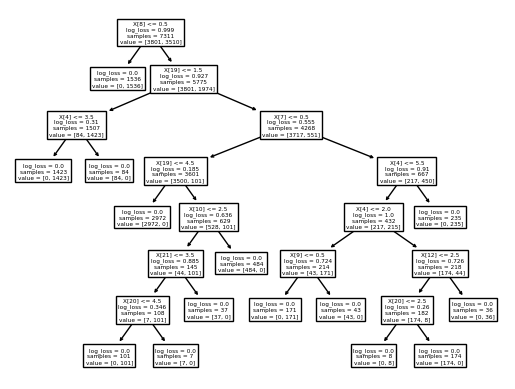

In [638]:
# Include decision tree visualization here
tree.plot_tree(decision_tree4, )

Discussion

As you can see in the tree, there is a depth of 7 on this tree. It doesn't descibe the names of the features in the splits. I like how it gives the log loss at each step though. It makes it clear which nodes are better than others. All the leaf nodes have a loss of 0 as well.

## 4. (Optional 5% extra credit) Implement reduced error pruning to help avoid overfitting
- You will need to take a validation set out of your training data to do this, while still having a test set to test your final accuracy. 
- Create a table comparing your decision tree implementation's results on the cars and voting data sets with and without reduced error pruning. 
- This table should compare:
    - a) The # of nodes (including leaf nodes) and tree depth of the final decision trees 
    - b) The generalization (test set) accuracy. (For the unpruned 10-fold CV models, just use their average values in the table).

In [ ]:
# Reduced Error Pruning Code

Discussion